In [5]:
!pip install eco2ai

In [6]:
import sys
sys.path.append('/kaggle/input/attentionsnn/pytorch/attentionsnn/1')

import torch
import torch.nn as nn
import torch.optim as optim
from torchsummary import summary
from torch.optim.lr_scheduler import ReduceLROnPlateau, CosineAnnealingLR, CosineAnnealingWarmRestarts

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
import cv2

import albumentations as A
from albumentations.pytorch import ToTensorV2

from tqdm import tqdm

from simple_utils import (
    save_checkpoint,
    load_checkpoint,
    get_loaders,
    check_accuracy,
    save_predictions_as_imgs,
    summarize_eco2ai_log,
    )

import resnet_2

from datetime import datetime
import glob
import random

from eco2ai import Tracker
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = resnet_2.resnet34().to(device)

In [8]:
summary(model, input_size=(1, 256, 256), batch_size=32)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
        Snn_Conv2d-1      [32, 2, 64, 128, 128]           3,136
      BatchNorm3d1-2      [32, 64, 1, 128, 128]             128
     batch_norm_2d-3      [32, 2, 64, 128, 128]               0
        mem_update-4      [32, 2, 64, 128, 128]               0
        Snn_Conv2d-5        [32, 2, 64, 64, 64]          36,864
      BatchNorm3d1-6        [32, 64, 1, 64, 64]             128
     batch_norm_2d-7        [32, 2, 64, 64, 64]               0
        mem_update-8        [32, 2, 64, 64, 64]               0
        Snn_Conv2d-9        [32, 2, 64, 64, 64]          36,864
     BatchNorm3d2-10        [32, 64, 1, 64, 64]             128
   batch_norm_2d1-11        [32, 2, 64, 64, 64]               0
AdaptiveAvgPool3d-12          [32, 64, 1, 1, 1]               0
           Conv3d-13           [32, 8, 1, 1, 1]             512
             ReLU-14           [32, 8, 

In [9]:
IMG_DIR      =  "/kaggle/input/braindataset/Modified_3_Brain_Tumor_Segmentation/images"
MASK_DIR     =  "/kaggle/input/braindataset/Modified_3_Brain_Tumor_Segmentation/masks"
VAL_IMG_DIR  =  "/kaggle/input/braindataset/Modified_3_Brain_Tumor_Segmentation/val_images"
VAL_MASK_DIR =  "/kaggle/input/braindataset/Modified_3_Brain_Tumor_Segmentation/val_masks"

In [10]:
Device = "cuda" if torch.cuda.is_available() else "cpu"
Learning_rate = 1e-3
Batch_size  = 32
num_epochs  = 60
num_workers = 4
IMAGE_HEIGHT = 256 
IMAGE_WIDTH  = 256  
PIN_MEMORY = True
LOAD_MODEL = False
CHECKPOINT_NAME = None

In [11]:
class DiceLoss(nn.Module):
    def __init__(self, smooth=1e-8):
        super(DiceLoss, self).__init__()
        self.smooth = smooth

    def forward(self, inputs, targets):
        inputs = torch.sigmoid(inputs)
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        intersection = (inputs * targets).sum()
        dice = (2. * intersection + self.smooth) / (inputs.sum() + targets.sum() + self.smooth)
        return 1 - dice

In [12]:
def train_fn(loader, model, optimizer, loss_fn, dice_loss_fn, scaler):

    tracker = Tracker(
        project_name="attentionSNN_Training_Project",
        experiment_description="Training CSA Spiking Upsampling Layer Model",
        file_name="attentionSNN_eco2ai_logs.csv",
        alpha_2_code="EG",  
    )
    tracker.start()

    loop = tqdm(loader)
    running_loss=0

    for batch_idx, (data, targets) in enumerate(loop):
        data = data.to(device=Device)
        targets = targets.float().unsqueeze(1).to(device=Device) 

        with torch.amp.autocast(device_type=Device):
            predictions = model(data)
            loss = loss_fn(predictions, targets)
            # dice_loss = dice_loss_fn(predictions, targets)
            # loss += dice_loss  # Combined hybrid loss
        
        running_loss+=loss.item()

        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
        loop.set_postfix(loss=loss.item())
    
    tracker.stop()

    nasar = model.calculate_nasar()
    
    return running_loss/len(loader), nasar 

In [13]:
def main():
    train_transform = A.Compose(
        [
            A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
            A.Rotate(limit=35, p=1.0),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.1),
            A.Normalize(
                mean=[0.0],
                std=[1.0],
                max_pixel_value=255.0,
            ),
            ToTensorV2(),
        ]
    )
    val_transform = A.Compose(
        [
            A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
            A.Normalize(
                mean=[0.0],
                std=[1.0],
                max_pixel_value=255.0,
            ),
            ToTensorV2(),
        ]
    )
    model = resnet_2.resnet34().to(device)
    loss_fn = nn.BCEWithLogitsLoss()
    dice_loss_fn = DiceLoss()
    optimizer = optim.Adam(model.parameters(), lr=Learning_rate)
    # scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.5)
    # scheduler = CosineAnnealingLR(optimizer, T_max=num_epochs)  
    scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2)

    train_loader, val_loader = get_loaders(
        IMG_DIR,
        MASK_DIR,
        VAL_IMG_DIR,
        VAL_MASK_DIR,
        Batch_size,
        train_transform,
        val_transform,
        num_workers,
        PIN_MEMORY,
    )

    train_losses=[]
    val_dice_scores=[]
    val_accs=[]
    train_nasar=[]

    if LOAD_MODEL:
        load_checkpoint(model=model, optimizer=optimizer, checkpoint_name=CHECKPOINT_NAME)
        val_acc_loaded, val_dice_loaded = check_accuracy(val_loader, model, device=Device)

    scaler = torch.amp.GradScaler()

    for epoch in range(num_epochs):
        train_fn(train_loader, model, optimizer, loss_fn, dice_loss_fn, scaler)

In [14]:
if __name__ == "__main__":
    main()

100%|██████████| 82/82 [00:32<00:00,  2.50it/s, loss=0.663]


NASAR: 0.14548398769967924


100%|██████████| 82/82 [00:31<00:00,  2.62it/s, loss=0.62] 


NASAR: 0.14825806036228087


100%|██████████| 82/82 [00:31<00:00,  2.57it/s, loss=0.582]


NASAR: 0.14512045015164507


100%|██████████| 82/82 [00:31<00:00,  2.57it/s, loss=0.549]


NASAR: 0.14083305296859122


100%|██████████| 82/82 [00:32<00:00,  2.53it/s, loss=0.519]


NASAR: 0.13882401008916095


100%|██████████| 82/82 [00:32<00:00,  2.55it/s, loss=0.49] 


NASAR: 0.14030336829704967


100%|██████████| 82/82 [00:32<00:00,  2.55it/s, loss=0.463]


NASAR: 0.15031982049709414


100%|██████████| 82/82 [00:32<00:00,  2.55it/s, loss=0.437]


NASAR: 0.14230845381573934


100%|██████████| 82/82 [00:32<00:00,  2.55it/s, loss=0.417]


NASAR: 0.14855171141585682


100%|██████████| 82/82 [00:32<00:00,  2.55it/s, loss=0.394]


NASAR: 0.14843699137369792


100%|██████████| 82/82 [00:32<00:00,  2.55it/s, loss=0.373]


NASAR: 0.14662956920096545


100%|██████████| 82/82 [00:32<00:00,  2.55it/s, loss=0.355]


NASAR: 0.14110232717622587


100%|██████████| 82/82 [00:32<00:00,  2.55it/s, loss=0.338]


NASAR: 0.15669363998785252


100%|██████████| 82/82 [00:32<00:00,  2.55it/s, loss=0.322]


NASAR: 0.14936450865210557


100%|██████████| 82/82 [00:32<00:00,  2.55it/s, loss=0.308]


NASAR: 0.1530129595500667


100%|██████████| 82/82 [00:32<00:00,  2.55it/s, loss=0.295]


NASAR: 0.14796653685530997


100%|██████████| 82/82 [00:32<00:00,  2.55it/s, loss=0.284]


NASAR: 0.15193274893411776


100%|██████████| 82/82 [00:32<00:00,  2.55it/s, loss=0.269]


NASAR: 0.1487224857981612


100%|██████████| 82/82 [00:32<00:00,  2.55it/s, loss=0.257]


NASAR: 0.1560032107965733


100%|██████████| 82/82 [00:32<00:00,  2.55it/s, loss=0.246]


NASAR: 0.15979131062825522


100%|██████████| 82/82 [00:32<00:00,  2.55it/s, loss=0.232]


NASAR: 0.16069804245863503


100%|██████████| 82/82 [00:32<00:00,  2.55it/s, loss=0.221]


NASAR: 0.15696389423153265


100%|██████████| 82/82 [00:32<00:00,  2.55it/s, loss=0.213]


NASAR: 0.1580513434681466


100%|██████████| 82/82 [00:32<00:00,  2.55it/s, loss=0.212]


NASAR: 0.16205948620307736


100%|██████████| 82/82 [00:32<00:00,  2.55it/s, loss=0.196]


NASAR: 0.1633397978495776


100%|██████████| 82/82 [00:32<00:00,  2.55it/s, loss=0.192]


NASAR: 0.1587876854873285


100%|██████████| 82/82 [00:32<00:00,  2.55it/s, loss=0.183]


NASAR: 0.15972321673137385


100%|██████████| 82/82 [00:32<00:00,  2.55it/s, loss=0.178]


NASAR: 0.15909172616353848


100%|██████████| 82/82 [00:32<00:00,  2.55it/s, loss=0.172]


NASAR: 0.16687586094305767


100%|██████████| 82/82 [00:32<00:00,  2.55it/s, loss=0.161]


NASAR: 0.16514850399358486


100%|██████████| 82/82 [00:32<00:00,  2.55it/s, loss=0.16] 


NASAR: 0.1645073867425686


100%|██████████| 82/82 [00:32<00:00,  2.55it/s, loss=0.149]


NASAR: 0.16393021374213987


100%|██████████| 82/82 [00:32<00:00,  2.55it/s, loss=0.146]


NASAR: 0.1625617360681053


100%|██████████| 82/82 [00:32<00:00,  2.55it/s, loss=0.141]


NASAR: 0.16258268899064723


100%|██████████| 82/82 [00:32<00:00,  2.55it/s, loss=0.139]


NASAR: 0.16315845396460557


100%|██████████| 82/82 [00:32<00:00,  2.55it/s, loss=0.134]


NASAR: 0.16801929628945947


100%|██████████| 82/82 [00:32<00:00,  2.55it/s, loss=0.126]


NASAR: 0.17065427206396086


100%|██████████| 82/82 [00:32<00:00,  2.55it/s, loss=0.128]


NASAR: 0.16339254611875953


100%|██████████| 82/82 [00:32<00:00,  2.55it/s, loss=0.122]


NASAR: 0.1725428325373952


100%|██████████| 82/82 [00:32<00:00,  2.55it/s, loss=0.115]


NASAR: 0.17153349465470974


100%|██████████| 82/82 [00:32<00:00,  2.55it/s, loss=0.11] 


NASAR: 0.17160468372872206


100%|██████████| 82/82 [00:32<00:00,  2.55it/s, loss=0.125]


NASAR: 0.170006927242124


100%|██████████| 82/82 [00:32<00:00,  2.55it/s, loss=0.112]


NASAR: 0.17420376413236788


100%|██████████| 82/82 [00:32<00:00,  2.55it/s, loss=0.0995]


NASAR: 0.17234592592813136


100%|██████████| 82/82 [00:32<00:00,  2.55it/s, loss=0.0998]


NASAR: 0.1739813889914412


100%|██████████| 82/82 [00:32<00:00,  2.55it/s, loss=0.0916]


NASAR: 0.17413438626421177


100%|██████████| 82/82 [00:32<00:00,  2.55it/s, loss=0.0959]


NASAR: 0.17662480051924542


100%|██████████| 82/82 [00:32<00:00,  2.55it/s, loss=0.095] 


NASAR: 0.1784097562960493


100%|██████████| 82/82 [00:32<00:00,  2.55it/s, loss=0.0901]


NASAR: 0.17993441325862233


100%|██████████| 82/82 [00:32<00:00,  2.55it/s, loss=0.0925]


NASAR: 0.18379318113249493


100%|██████████| 82/82 [00:32<00:00,  2.55it/s, loss=0.0843]


NASAR: 0.1763490816441978


100%|██████████| 82/82 [00:32<00:00,  2.55it/s, loss=0.0835]


NASAR: 0.17947820647945248


100%|██████████| 82/82 [00:32<00:00,  2.55it/s, loss=0.0843]


NASAR: 0.18093769724776104


100%|██████████| 82/82 [00:32<00:00,  2.55it/s, loss=0.0766]


NASAR: 0.17800244587223704


100%|██████████| 82/82 [00:32<00:00,  2.55it/s, loss=0.0809]


NASAR: 0.17691602009098703


100%|██████████| 82/82 [00:32<00:00,  2.55it/s, loss=0.0799]


NASAR: 0.17466302266935022


100%|██████████| 82/82 [00:32<00:00,  2.55it/s, loss=0.074] 


NASAR: 0.17996444702148437


100%|██████████| 82/82 [00:32<00:00,  2.55it/s, loss=0.07]  


NASAR: 0.18267471809697344


100%|██████████| 82/82 [00:32<00:00,  2.55it/s, loss=0.073] 


NASAR: 0.18327061102642275


100%|██████████| 82/82 [00:32<00:00,  2.55it/s, loss=0.0671]


NASAR: 0.1840220319546335


✅ Log loaded successfully.

🔍 Summary:
   🕒 Duration: 1939.52 seconds
   ⚡ Power Consumed: 0.0485 kWh
   🌱 CO₂ Emissions: 0.0228 kg
✅ Summary plot saved as 'attentionSNN_eco2ai_summary_plot.png'.


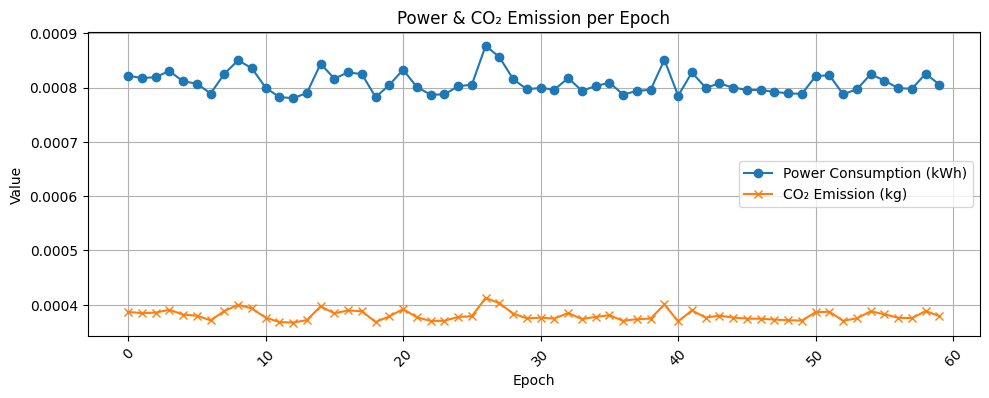

In [15]:
summarize_eco2ai_log("attentionSNN_eco2ai_logs.csv")